In [1]:
from MutantTool import Placeholder, QCSetUp, mutant_generator
from basicFunctions import xor, input_generator

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Instruction 
from qiskit.circuit.gate import Gate
from qiskit_textbook.tools import simon_oracle

from MutantTool import mutant_generator
from basicFunctions import xor
import random
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.providers.aer import QasmSimulator


svsim = Aer.get_backend('aer_simulator')
simulator = QasmSimulator()

In [2]:
def Simon_Alg_MT(n:int) -> QuantumCircuit:
    
    qs=QuantumRegister(n, 's')
    anc=QuantumRegister(n, 'anc')
    qc = QuantumCircuit(qs, anc)

    for i in range(n): qc.h(i)

    qc.barrier()
    qc.append(Placeholder(qc.num_qubits, qc.qubits))
    qc.barrier()
    
    for i in range(n): qc.h(i) 
    
    return qc

def sumgate(n: int) -> QuantumCircuit:
    qubits=4*n
    qc = QuantumCircuit(qubits)
    for i in range(n):
        qc.cx(i,2*n+i)
    return qc

def Simon_MT1(mutant:QuantumCircuit, input: str) -> QuantumCircuit:

    assert mutant.num_qubits % 2 == 0
    
    n = mutant.num_qubits//2
           
    qs=QuantumRegister(n, 's')
    anc=QuantumRegister(n, 'anc1')
    qs1=QuantumRegister(n, 's1')
    anc1=QuantumRegister(n, 'anc2')
    c_test=ClassicalRegister(n, 'c_test')
    qc = QuantumCircuit(qs, anc, qs1, anc1, c_test)
    
    f_s=simon_oracle(input)
    gate_s = QCSetUp(mutant,f_s)
    gate_s.name='  Simon_oracle  \n \ns='+ input
    qc.append(gate_s, range(2*n))
    qc.append(gate_s, range(2*n,4*n))
    
    qc.barrier()
    
    suma = sumgate(n)
    sgate = suma.to_instruction(label='  Metamorphic \n\n Relation \n\n Outputs')
    qc.append(sgate, range(4*n))
    for i in range(n):
        qc.measure(2*n+i, i)
    
    qc.draw(output='mpl')
    
    return qc

def Simon_MT_Aux(mutant:QuantumCircuit, input: str, inv:bool=False) -> QuantumCircuit:

    assert mutant.num_qubits % 2 == 0
    
    n = mutant.num_qubits//2
           
    qs=QuantumRegister(n, 's')
    anc=QuantumRegister(n, 'anc1')
    c_test=ClassicalRegister(n, 'c_test')
    qc = QuantumCircuit(qs, anc, c_test)

    if inv:
        input = input[::-1]
        
    f_s=simon_oracle(input)
    gate_s = QCSetUp(mutant,f_s)
    gate_s.name='  Simon_oracle  \n \ns='+ input
    qc.append(gate_s, range(2*n))
    
    qc.barrier()
    
    for i in range(n):
        qc.measure(i, i)
    
    qc.draw(output='mpl')
    
    return qc



In [3]:
def Simon_Analysis(results: tuple[dict[str,int],dict[str,int]], MR1 : bool) -> bool:
    
    if MR1:
        analysis = (results[0].keys() == results[1].keys())
        #It does work as order doesn't matter, .keys() are set-like
        
    else:
        analysis = (results[0].keys() == {i[::-1] for i in results[1].keys()})
    
    return analysis    
    

def mutation_MT_Simon(MR1 : bool, num_qubits: int, num_mutants : int, rep : int, num_max_inputs=20) : 
    
    originalQC = Simon_Alg_MT(num_qubits)
    mutants = mutant_generator(originalQC, num_mutants)

    input_list = input_generator(num_qubits, num_max_inputs)

    results=[]
    total=0
    final_inputs=set()
    
    for x in mutants:
        killed = False
        i = 0
        
        if MR1:
            results_x = svsim.run(transpile(Simon_MT_Aux(x,input_list[i]),svsim),shots=rep).result().get_counts()
            
        while not killed and i < len(input_list):

            if MR1:
            
                results_x_i=svsim.run(transpile(Simon_MT1(x,input_list[i]),svsim),shots=rep).result().get_counts()

            else:

                results_x_i = svsim.run(transpile(Simon_MT_Aux(x,input_list[i]),svsim),shots=rep).result().get_counts()
                results_x = svsim.run(transpile(Simon_MT_Aux(x,input_list[i],inv=True),svsim),shots=rep).result().get_counts()
            
            if not Simon_Analysis((results_x_i,results_x),MR1):
                killed = True
                final_inputs.add(input_list[i])
        
            i += 1
            
        total += i  
        results.append(killed)

    mutants_killed = sum(results)
    
    print(results)
    
    print("Mutants Killed: ",mutants_killed)
    
    print("Mutantion Score: ",mutants_killed/len(results)*100,"%")

    print("Total test executed: ",total)

    print("Set of inputs used to kill mutants: ", final_inputs)
    
    print("Set of inputs used: ", input_list)

    return [mutants[i] for i in range(len(mutants)) if not results[i]]

In [4]:
num_qubits = 3
num_mutants = 10
rep = 1024
mutation_MT_Simon(True, num_qubits, num_mutants, rep)

[True, True, True, True, True, True, True, True, True, True]
Mutants Killed:  10
Mutantion Score:  100.0 %
Total test executed:  22
Set of inputs used to kill mutants:  {'001', '010'}
Set of inputs used:  ['000', '001', '010', '011', '100', '101', '110', '111']


[]

In [5]:
num_qubits = 5
num_mutants = 10
rep = 1024
notkilled=mutation_MT_Simon(False, num_qubits, num_mutants, rep)

[True, False, False, True, False, True, True, True, True, True]
Mutants Killed:  7
Mutantion Score:  70.0 %
Total test executed:  80
Set of inputs used to kill mutants:  {'00001', '11101', '11110'}
Set of inputs used:  ['00001', '11110', '01010', '11101', '00110', '10110', '01101', '10100', '01001', '00101', '00000', '10001', '10111', '00011', '00100', '10101', '01110', '00010', '11111', '00111']


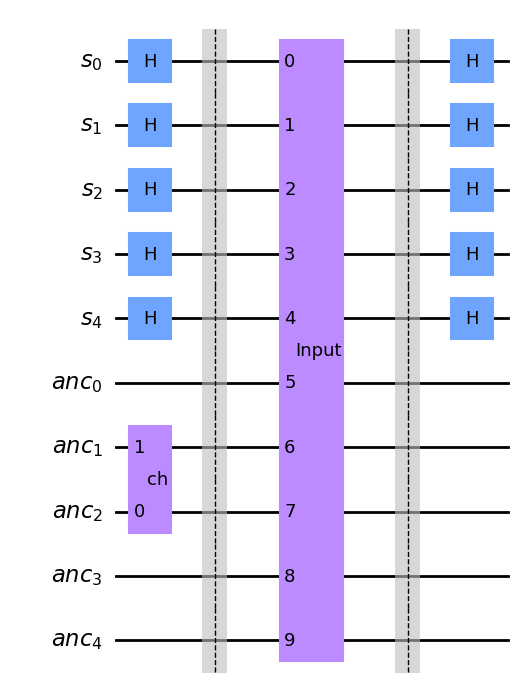

In [6]:
notkilled[0].draw(output='mpl')

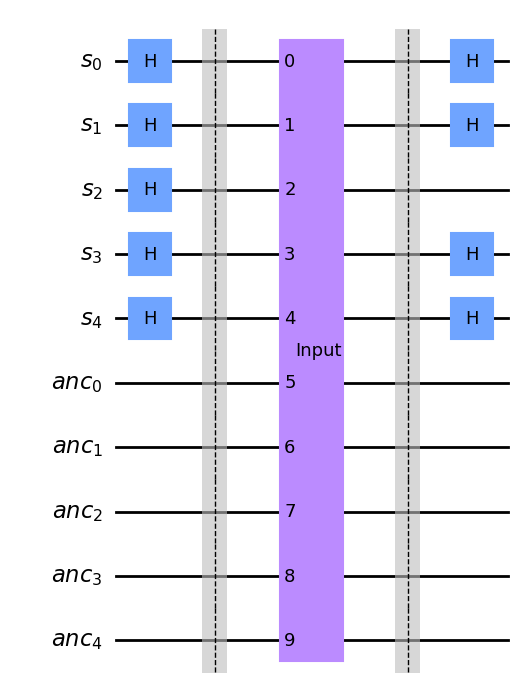

In [7]:
notkilled[1].draw(output='mpl')

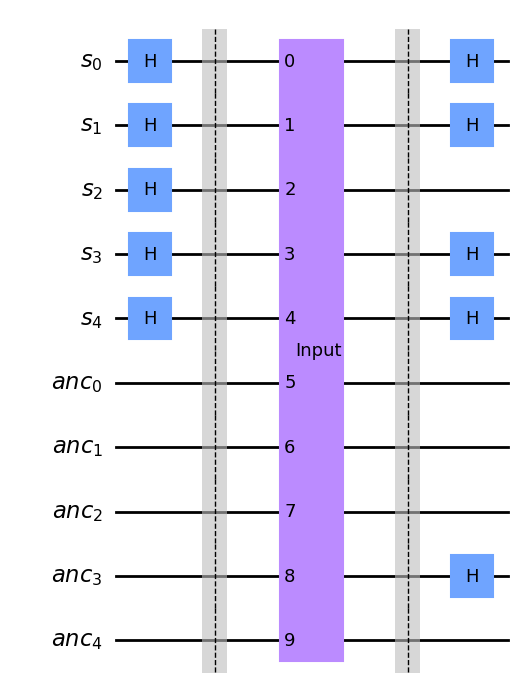

In [8]:
notkilled[2].draw(output='mpl')